['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


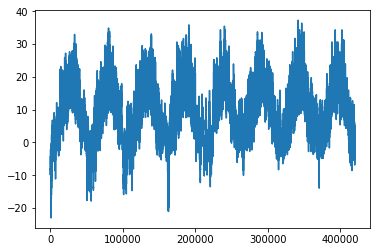

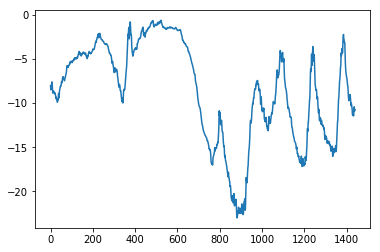

In [3]:
import os

fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

# 将所有420551行数据转换为Numpy数组

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 温度（以摄氏度为单位）随时间变化的曲线图：
from matplotlib import pyplot as plt

temp = float_data[:, 1]  #  温度（以摄氏度为单位）
plt.plot(range(len(temp)), temp)
plt.show()

# 在图中，可以清楚地看到温度的年度周期。
# 这是前十天温度数据的更窄的图（由于数据每十分钟记录一次，每天可以得到144个数据点）
plt.plot(range(1440), temp[:1440])
plt.show()

'''
在图中，可以看到每日周期，尤其是过去4天。还可以注意到，这十天的时间必须来自一个相当寒冷的冬季。
如果试图在给定几个月的过去数据的情况下预测下个月的平均温度，由于数据的可靠年度周期性，问题将很容易。
但是，在几天的时间内查看数据，温度看起来更加混乱。那么这个时间序列是否可以在日常范围内预测？。
准备数据
问题的确切表述如下：给定的数据可以追溯到“回顾”时间步长（时间步长为10分钟）并对每个“步”时间步进行采样,可以预测“延迟”时间步长的温度吗？
将使用以下参数值：
 *`lookback = 720`，即观察将会回溯5天。
 *`steps = 6`，即观察将在每小时一个数据点进行采样。
 *`delay = 144`，即目标将来是24小时。
 首先，需要做两件事：
 *将数据预处理为神经网络可以摄取的格式。这很简单：数据已经是数字的，因此我们不需要进行任何矢量化。
然而，数据中的每个时间序列处于不同的比例（例如，温度通常在-20和+30之间，但是以mbar测量的压力大约是1000）。因此，
将独立地对每个时间序列进行标准化，以便它们都以相似的比例取小值。
 *编写一个Python生成器，它接收当前的浮点数据数组，并产生最近过去的批量数据，以及一个
＃将来的目标温度。由于数据集中的样本是高度冗余的（例如样本“N”和样本“N + 1”将具有共同的大部分时间步长），因此明确分配每个样本将是非常浪费的。
相反，将使用原始数据动态生成样本。
通过减去每个时间序列的平均值并除以标准偏差来预处理数据。我们计划使用前200,000个时间步作为训练数据，因此我们仅计算这部分数据的平均值和标准差：
'''
mean = float_data[: 200000].mean(axis=0)
float_data -= mean
std = float_data[: 200000].std(axis=0)
float_data /= std


'''
将使用的数据生成器。 它产生一个元组`（样本，目标）`其中`samples`是一批输入数据和
  `targets`是相应的目标温度阵列。 它需要以下参数：
*`data`：浮点数据的原始数组，已经在上面的代码片段中对其进行了规范化。
*`lookback`：输入数据应该返回多少次。
  *`delay`：未来我们的目标应该是多少次。
  *`min_index`和`max_index`：`data`数组中的索引，用于分隔要绘制的时间步长。 这对于保留细分非常有用
  用于验证的数据和用于测试的另一个数据。
  *`shuffle`：是否按照时间顺序对样品进行洗牌或绘制。
  *`batch_size`：每批样本数。
*`step`：采样数据的时间段，在时间步长。 将其设置为6以便每小时绘制一个数据点。
'''
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        # 可以把yield的功效理解为暂停和播放。
        # 在一个函数中，程序执行到yield语句的时候，程序暂停，返回yield后面表达式的值，
        # 在下一次调用的时候，从yield语句暂停的地方继续执行，如此循环，直到函数执行完
        yield samples, targets

In [5]:
# 现在让我们使用抽象生成器函数来实例化三个生成器，一个用于训练，一个用于验证，一个用于测试。
# 每个都将查看原始数据的不同时间段：训练生成器查看前200,000个步骤，验证生成器查看以下100,000个，
# 并且测试生成器查看剩余部分。
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [6]:
# 从`val_gen`中抽取多少步骤以查看整个验证集：
val_steps = (300000 - 200001 - lookback) // batch_size

In [7]:
# 从`test_gen`中抽取多少步骤以查看整个测试集：
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
'''
常识，非机器学习基线
在开始利用黑盒深度学习模型来解决温度预测问题之前，先尝试一种简单的常识方法
。它将作为一个健全性检查，它将建立一个必须击败的基线，以证明更先进的机器
学习模型的有用性。当接近尚未知解决方案的新问题时，这种常识基线可能非常有用。
一个典型的例子是不平衡的分类任务，其中一些类可能比其他类更常见。如果数据集
包含90％的A类实例和10％B类实例，那么分类任务的常识方法是在呈现新样本时始终
预测“A”。这样的分类器总体上将是90％准确，因此任何基于学习的方法都应该超过
这个90％的分数以证明有用性。有时，这种基本基线可能难以击败。
在温度预测的例子中，可以安全地假设温度时间序列是连续的（明天的温度可能接近
今天的温度）以及每日期间的周期。因此，常识方法是始终预测从现在起24小时后的温度
将等于现在的温度。让我们使用平均绝对误差度量（MAE）来评估这种方法.
Mean Absolute Error简单地等于：
'''
# np.mean(np.preds - targets)
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()

0.2897359729905486


In [14]:
'''
它产生的MAE为0.29。由于温度数据已经标准化为以0为中心并且标准偏差为1，因此
该数字不能立即解释。它转换为平均绝对误差“0.29 * temperature_std”摄氏度，
即2.57˚C。这是一个相当大的平均绝对误差 - 

接下来是进行改进：
一种基本的机器学习方法
以在尝试机器学习方法之前建立常识基线有用的方式相同，在研究复杂且计算量大的
模型之前尝试简单且廉价的机器学习模型（例如小型密集连接网络）是有用的。 RNNs。
这是确保我们以后针对该问题提出的任何进一步复杂性是合法的并提供真正好处的最佳方法。
这是一个简单的完全连接模型，首先展平数据，然后通过两个“密集”层运行它。
请注意最后一个'Dense`图层缺少激活功能，这是回归问题的典型特征。使用MAE作为损失。
由于正在评估完全相同的数据并使用与我们的常识方法完全相同的指标，因此结果将直接具有可比性。
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
500/500 [==============================] - 16s 31ms/step - loss: 1.4277 - val_loss: 0.6786
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 0.5052 - val_loss: 0.4064
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3042 - val_loss: 0.3297
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2678 - val_loss: 0.3017
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2563 - val_loss: 0.3198
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2441 - val_loss: 0.3191
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2366 - val_loss: 0.3261
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2323 - val_loss: 0.3140
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2282 - val_loss: 0.3192
Epoch 10/

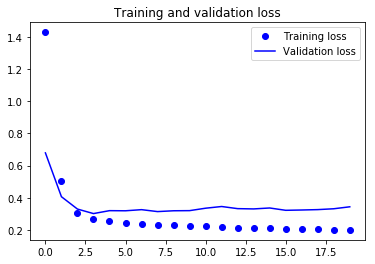

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
'''
一些验证损失接近无学习基线，但不是非常可靠。这表明首先有这个基线的优点：
事实证明并不那么容易。
如果存在一个简单，表现良好的模型，从数据到目标（我们的常识基线），为什么
正在训练的模型不能找到并改进它？简单地说：因为这个简单的解决方案不是训练
设置所需要的。寻找解决方案的模型空间，即假设空间，是具有定义的配置的所有
可能的2层网络的空间。这些网络已经相当复杂。当寻找具有复杂模型空间的解决
方案时，简单的良好性能基线可能是无法获得的，即使它在技术上是假设空间的
一部分。这通常是机器学习的一个非常重要的限制：除非学习算法被硬编码以寻
找特定类型的简单模型，否则参数学习有时无法找到简单问题的简单解决方案。

第一个复发基线
第一个完全连接的方法并不是那么好，但这并不意味着机器学习不适用于问题。
上面的方法包括首先展平时间序列，从输入数据中删除时间概念。数据是什么：
一个序列，因果关系和秩序很重要。接下来将尝试一种循环序列处理模型 - 
它应该是这种序列数据的完美拟合，正是因为它确实利用了数据点的时间排序，
这与第一种方法不同。
接下来将使用由Cho等人开发的`GRU`层，而不是上一节中介绍的`LSTM`层。在2014
年，`GRU`层（代表“门控循环单元”）通过利用与LSTM相同的原理工作，但它们
有些精简，因此运行起来更便宜，尽管它们可能没有LSTM那么多的代表性能力。
计算代价和代表性能力之间的这种权衡在机器学习中随处可见。
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=5,  # 最好多训练几轮，比如20轮，为了展示方便我只训练了5轮
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 109s 218ms/step - loss: 0.2611 - val_loss: 0.2629
Epoch 2/5
500/500 [==============================] - 105s 210ms/step - loss: 0.2576 - val_loss: 0.2700
Epoch 3/5
500/500 [==============================] - 108s 217ms/step - loss: 0.2546 - val_loss: 0.2732
Epoch 4/5
500/500 [==============================] - 110s 220ms/step - loss: 0.2478 - val_loss: 0.2746
Epoch 5/5
500/500 [==============================] - 110s 220ms/step - loss: 0.2439 - val_loss: 0.2716


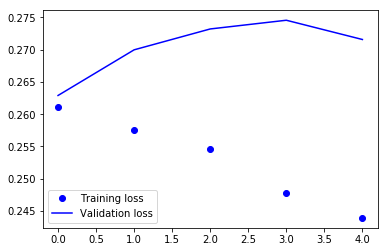

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# 绘制损失曲线
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.show()

In [23]:
'''
上述效果比第一种方式好了很多！能够显着击败基准基线，这样就证明了机器学习的价值，
以及与此类任务中的序列扁平化密集网络相比，循环网络的优越性。
新的验证MAE约为0.265（训练20轮左右，在我们开始显着过度拟合之前）转换为去标准化后的平均绝对误差2.35˚C。
这是我们初始误差2.57˚C的稳固增长，但我们可能还有一些改进余地。

使用recurrent dropout来削弱过度拟合
从训练和验证曲线可以看出，模型过度拟合：训练和验证损失在几个时期之后开始显着不同。
解决的方式：‘dorpout’丢失，包括随机清零图层的输入单元，以打破图层暴露的训练数据中的偶然相关性。
但是，如何在经常性网络中正确应用dropout并不是一个微不足道的问题。人们早就知道，在recurrent layer(循环层）
之前应用辍学会阻碍学习而不是帮助正规化。
2015年，Yarin Gal，作为博士学位的一部分。关于贝叶斯深度学习的论文，确定了使用丢失与循环网络的正确方法
：应该在每个时间步应用相同的丢失掩码（相同的丢弃单位模式），而不是从时间步长到时间步长随机变化的丢失掩码。
更重要的是：为了规范由GRU和LSTM等层的循环门形成的表示，应该对层的内部循环激活应用时间上恒定的丢失掩模
（“循环”丢失掩码）。在每个时间步使用相同的丢失掩码允许网络在时间上正确地传播其学习错误;一个暂时的
随机丢失掩码会破坏这个错误信号并对学习过程有害。
Yarin Gal使用Keras进行了他的研究，并帮助将这种机制直接构建到Keras recurrent layer。 Keras中的每个循环层都有两个
与dropout相关的参数：`dropout`，一个指定图层输入单位的丢失率的浮点数，以及`recurrent_dropout`，
指定循环单位的丢失率。让我们在我们的GRU层添加丢失和重复丢失，看看它如何影响过度拟合。由于网络正常化
与丢失总是需要更长时间才能完全收敛，因此我们训练网络的时间是原来的两倍。

'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [25]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=5,  # 最好多训练几轮，比如40轮，为了展示方便我只训练了5轮
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 347s 693ms/step - loss: 0.3205 - val_loss: 0.2753
Epoch 2/5
500/500 [==============================] - 353s 706ms/step - loss: 0.3047 - val_loss: 0.2664
Epoch 3/5
500/500 [==============================] - 367s 735ms/step - loss: 0.2982 - val_loss: 0.2667
Epoch 4/5
500/500 [==============================] - 431s 863ms/step - loss: 0.2909 - val_loss: 0.2603
Epoch 5/5
500/500 [==============================] - 398s 796ms/step - loss: 0.2887 - val_loss: 0.2614


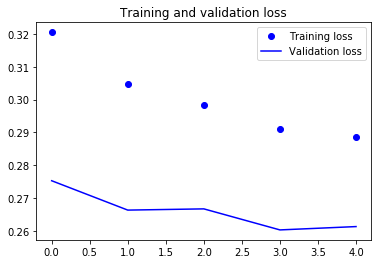

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
'''
可以看到，增加的层确实提升了效果，虽然不是很显着。可以得出两个结论：
*由于我们仍然没有过度拟合，可以安全地增加层的大小，以寻求一点验证损失改进。
但是，这确实具有不可忽略的计算成本。
*由于添加一个层并没有产生重大影响，因此可能会看到此时增加网络容量的收益递减。
使用双向RNN | Using bidirectional RNNs
将在本节中介绍的最后一种技术称为“bidirectional RNNs”。双向RNN是常见的RNN变体，
其在某些任务上可以提供比常规RNN更高的性能。它经常用于自然语言处理 - 可以把它称为NLP的深度学习的瑞士军刀。
RNN特别依赖于顺序或时间依赖性：它们按顺序处理其输入序列的时间步长，并且改组或反转时间步长可以
完全改变RNN将从序列中提取的表示。这正是他们在订单有意义的问题上表现良好的原因，例如温度预测问题。
双向RNN利用RNN的顺序灵敏度：它只包含两个常规RNN，例如您已经熟悉的GRU或LSTM层，每个都在一个方向上处理
输入序列（按时间顺序和反时间顺序），然​​后合并它们的表示。通过双向处理序列，双向RNN能够捕获可能被单向R
NN忽略的模式。
值得注意的是，本节中的RNN层到目前为止按时间顺序处理序列（较早的时间步长）可能是一个随意的决定。
。如果按照反时间顺序处理输入序列，需要做的就是编写一个数据生成器的变体，其中输入序列沿时间维度被恢复（
用`yield samples [：，:: - 1，：]，targets`替换最后一行）。培训与本节第一个实验中使用的相同的一个GRU层网络，
可以得到以下结果：
'''
def reverse_order_generator(data, lookback, delay, min_index, max_index, 
                           shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [38]:
train_gen_reverse = reverse_order_generator(float_data,
                                           lookback=lookback,
                                           delay=delay,
                                           min_index=0,
                                           max_index=200000,
                                           shuffle=True,
                                           step=step,
                                           batch_size=batch_size)
val_gen_reverse = reverse_order_generator(float_data,
                                         lookback=lookback,
                                         delay=delay,
                                         min_index=200001,
                                         max_index=300000,
                                         step=step,
                                         batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [40]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                             steps_per_epoch=500,
                             epochs=5,  # 最好多训练几轮，比如20轮，为了展示方便我只训练了5轮
                             validation_data=val_gen_reverse,
                             validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 112s 224ms/step - loss: 0.4485 - val_loss: 0.5172
Epoch 2/5
500/500 [==============================] - 118s 235ms/step - loss: 0.4002 - val_loss: 0.4899
Epoch 3/5
500/500 [==============================] - 123s 245ms/step - loss: 0.3611 - val_loss: 0.4645
Epoch 4/5
500/500 [==============================] - 129s 258ms/step - loss: 0.3371 - val_loss: 0.4634
Epoch 5/5
500/500 [==============================] - 130s 260ms/step - loss: 0.3213 - val_loss: 0.4609


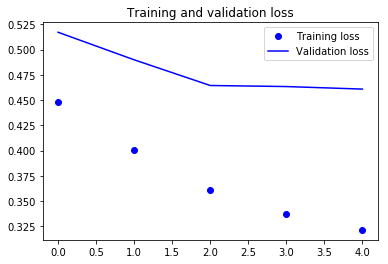

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
'''
逆序GRU甚至在常识基线上也表现不佳，这表明在案例中按时间顺序处理对于方法的成功非常重要。 
这是完全合理的：基础GRU层通常会更好地记住最近的过去而不是遥远的过去，并且自然地，最近的
天气数据点比问题中的旧数据点更具预测性（这正是使得常识的原因） 基线相当强的基线）。 因
此，层的时间顺序版本必然优于逆序版本。 重要的是，这通常不适用于许多其他问题，包括自然语
言：直觉上，单词在理解句子时的重要性通常不取决于其在句子中的位置。 
接下来在上一节的LSTM IMDB示例中尝试相同的技巧：
'''
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 考虑作为特征的单词数
max_features = 10000

maxlen = 500

# 加载数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
                     
#  reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)      